In [1]:
import tensorflow as tf
import numpy as np

In [2]:
HISTORY_TIMES = [3, 7, 15, 31, 47, 63, 95, 127]

PIECES = 256

ADDITIONAL_INPUT_SIZE = 6

voices = 5

In [3]:
import itertools
Y_combinations = []
comb_ids = []
for i in itertools.product([0, 1], repeat=12):
    if np.array(i).sum() > 5:
        comb_ids.append(0)
    else:
        comb_ids.append(len(Y_combinations))
        y = np.append(np.array(i), 1)
        y_combs = [y.copy()]

        ones = np.array(i).nonzero()[0]

        if len(ones) > 5:
            while len(y_combs) < 32:
                y_combs.append(np.zeros((13)))
        else:
            for a in range(len(ones)):
                y_combs.append(y.copy())
                y_combs[-1][ones[a]] = 0
            while len(y_combs) < 1 + 5:
                y_combs.append(np.zeros((13)))

            for a in range(len(ones)):
                for b in range(a+1, len(ones)):
                    y_combs.append(y.copy())
                    y_combs[-1][ones[a]] = 0
                    y_combs[-1][ones[b]] = 0
            while len(y_combs) < 1 + 5 + 10:
                y_combs.append(np.zeros((13)))

            for a in range(len(ones)):
                for b in range(a+1, len(ones)):
                    for c in range(b+1, len(ones)):
                        y_combs.append(y.copy())
                        y_combs[-1][ones[a]] = 0
                        y_combs[-1][ones[b]] = 0
                        y_combs[-1][ones[c]] = 0
            while len(y_combs) < 1 + 5 + 10 + 10:
                y_combs.append(np.zeros((13)))

            for a in range(len(ones)):
                for b in range(a+1, len(ones)):
                    for c in range(b+1, len(ones)):
                        for d in range(c+1, len(ones)):
                            y_combs.append(y.copy())
                            y_combs[-1][ones[a]] = 0
                            y_combs[-1][ones[b]] = 0
                            y_combs[-1][ones[c]] = 0
                            y_combs[-1][ones[d]] = 0
            while len(y_combs) < 1 + 5 + 10 + 10 + 5:
                y_combs.append(np.zeros((13)))

            y_combs.append(np.zeros((13)))   
            if len(ones) == 5:
                y_combs[-1][-1] = 1

        Y_combinations.append(y_combs)
        
Y_combinations = np.array(Y_combinations, dtype=np.float32)
comb_ids = np.array(comb_ids)
Signs = np.array([+1,
                  -1, -1, -1, -1, -1,
                  +1, +1, +1, +1, +1, +1, +1, +1, +1, +1,
                  -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
                  +1, +1, +1, +1, +1,
                  -1])

In [21]:
tf.reset_default_graph()

# Training Parameters
learning_rate = tf.constant(0.002, dtype=tf.float32)
batch_size = 90
epsilon = 1e-06

# Network Parameters
num_input = 12 + ADDITIONAL_INPUT_SIZE  # размер первого слоя
num_hidden_local = 100                  # размер второго слоя
num_hidden_read = 100                   # размер контроллера для внимания
num_hidden_aggreg = 100                 # размер агрегирующего слоя
num_hidden_voicegen = 40                # размер каждого генератора голоса
num_output = 12                         # размер выхода

num_hidden_decoder = 100                # размер скрытого слоя декодера
num_decoder_output = 88                 # размер выхода декодера

# Вход графа вычислений: песня, вектора истории для каждого момента времени, комбинации
X = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, num_input])
History = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, len(HISTORY_TIMES), num_output])
Combinations = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, 2**voices, num_output+1])

# второй слой
with tf.variable_scope("local"):
    local_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_local, forget_bias=1.0)])
    local_lstm_outputs, _ = tf.nn.dynamic_rnn(local_lstm, X[:, :-1], dtype=tf.float32)

# чтение из истории
with tf.variable_scope("global"):
    read_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_read, forget_bias=1.0)])
    read_lstm_outputs, _ = tf.nn.dynamic_rnn(read_lstm, X[:, :-1], dtype=tf.float32)
read_index = tf.nn.softmax(tf.layers.dense(read_lstm_outputs, len(HISTORY_TIMES), activation=None))
read = tf.reduce_mean(tf.expand_dims(read_index, 3) * History[:, :-1], axis=2)

# агрегация локальных и глобальных зависимостей
with tf.variable_scope("aggreg"):
    aggreg_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_aggreg, forget_bias=1.0)])
    aggreg_lstm_outputs, _ = tf.nn.dynamic_rnn(aggreg_lstm, tf.concat([read, local_lstm_outputs], axis=2), dtype=tf.float32)

# сюда будем складывать вероятности, с которым генерится каждый голос
voices_proba = []

# если этот флаг true, то на вход уже даны результаты сэмплирования из распределений голосов в truly_sampled_notes
was_sampled_notes_given = tf.placeholder(tf.bool)
truly_sampled_notes = tf.zeros([voices, batch_size, tf.shape(X)[1] - 2, num_output], dtype=tf.float32)
# сюда для удобства складываем то, что сэмплируется для каждого голоса
sampled_notes_by_voices = []
# результат сэмплирования (просто объединение элементов sampled_notes_by_voices)
sampled_notes = tf.zeros([batch_size, tf.shape(X)[1] - 1, num_output], dtype=tf.float32)

for v in range(voices):
    # пихаем в персональный микролстм
    with tf.variable_scope("voicegen" + str(v)):
        voicegen_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_voicegen, forget_bias=1.0)])
        voicegen_lstm_outputs, _ = tf.nn.dynamic_rnn(voicegen_lstm, tf.concat([aggreg_lstm_outputs, sampled_notes], axis=2), dtype=tf.float32)
    
        # линейно преобразуем к 13 числам и берём софтмакс. Это распределение, из которого надо сэмплировать очередную ноту
        voices_proba.append(tf.nn.softmax(tf.layers.dense(voicegen_lstm_outputs, (num_output+1), activation=None)))
    
    # зануляем те вероятности, которые, согласно правильному ответу, не могли засэмплироваться.
    aposter = tf.where(tf.cast(tf.concat([X[:, 1:, :num_output], tf.ones([batch_size, tf.shape(X)[1] - 1, 1])], axis=2), tf.bool), 
                       voices_proba[-1], tf.zeros([batch_size, tf.shape(X)[1] - 1, num_output+1], dtype=tf.float32))
    # сэмплируем для каждого батча и момента времени (из-за этого понадобилось два решэйпа) и преобразуем в one-hot
    sampled = tf.one_hot(
            # tf.multinomial is not working with 2D-batches...
            tf.reshape(tf.multinomial(logits=tf.reshape(tf.log(aposter), [-1, num_output+1]), num_samples=1), 
                                       [batch_size, -1]), depth=num_output)
    # мы либо знаем, какая нота сгенерилась в этом голосе, по входу, либо берём те, что сгенерировались сейчас
    sampled_notes_by_voices.append(tf.cond(was_sampled_notes_given, 
                                           lambda: tf.concat([truly_sampled_notes[v], sampled[:, -1:]], axis=1), 
                                           lambda: sampled))
    
    # итого мы засэмплировали ноту, если засэмплировали её раньше, или засэмплировали сейчас.
    sampled_notes = tf.stop_gradient(tf.where(tf.cast(sampled_notes, tf.bool), sampled_notes, sampled_notes_by_voices[-1]))
    # если мы обучаемся, already_sampled совпадает с sampled_notes. Иначе нужно использовать те результаты сэмплирования, которые дают

# получаем матрицу вероятностей сэмплирования нот: batch_size x timesteps x notes x voices
V = tf.transpose(tf.convert_to_tensor(voices_proba, dtype=tf.float32), [1, 2, 3, 0])

# рассчитываем вероятность того, что засэмплируется именно то, что было в данных.
p_of_truth = tf.matmul(tf.reduce_prod(tf.matmul(Combinations[:, 1:], V), axis=3), 
                       tf.tile(tf.constant(Signs[None, :, None], dtype=tf.float32), [batch_size, 1, 1]))
clip_p_of_truth = tf.clip_by_value(p_of_truth, epsilon, 1 - epsilon)

ce = -tf.log(clip_p_of_truth)
loss_op = tf.reduce_mean(ce)

# DECODER --------------

DecodedX = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, num_decoder_output])
DecoderInput = tf.concat([DecodedX[:, :-1], X[:, 1:, -ADDITIONAL_INPUT_SIZE:],
                          tf.cond(was_sampled_notes_given, lambda: sampled_notes, lambda: X[:, 1:, :-ADDITIONAL_INPUT_SIZE])], axis=2)
with tf.variable_scope("decoder"):
    decoder_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_decoder, forget_bias=1.0)])
    decoder_lstm_outputs, _ = tf.nn.dynamic_rnn(decoder_lstm, tf.concat([DecodedX[:, :-1], X[:, 1:]], axis=2), dtype=tf.float32)

decoder_p = tf.layers.dense(decoder_lstm_outputs, num_decoder_output, activation=None)

decoder_ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=decoder_p, labels=DecodedX[:, 1:])
loss_op += tf.reduce_mean(decoder_ce * 
            tf.tile(tf.cond(was_sampled_notes_given, lambda: sampled_notes, 
                            lambda: X[:, 1:, :-ADDITIONAL_INPUT_SIZE]), [1,1,8])[:,:,:num_decoder_output])
    
# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
gvs = optimizer.compute_gradients(loss_op)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)

#optimizing
#train_op = tf.contrib.layers.optimize_loss(
#                loss_op, tf.train.get_global_step(), optimizer=optimizer, learning_rate=learning_rate)

init = tf.global_variables_initializer()

In [22]:
# Start training, device_count = {"GPU": 0}
config = tf.ConfigProto(log_device_placement=True)  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.6  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)
sess = tf.Session(config = config)
saver = tf.train.Saver()

In [23]:
# Run the initializer
sess.run(init)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def drawNotes(song, name="", scale=(None, None)):
    if scale[0] is None:
        scale = (song.shape[0] / 10, song.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(name)
    plt.imshow(song.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.shape[0], 4))
    plt.show()

In [8]:
songs = np.load("CP_dataset.npy")

In [9]:
times = [np.array(t) for t in itertools.product([0, 1], repeat=ADDITIONAL_INPUT_SIZE)]*1000

In [10]:
def transform(song, stack_zeros=True):    
    wh = song[:, :12]
    for i in range(1,7):
        wh = np.logical_or(wh, song[:, 12*i:12*i+12])
    
    temp = wh.copy()
    for t in HISTORY_TIMES:
        h = np.roll(temp, t, axis=0)
        h[:t] = 0
        wh = np.concatenate([wh, h], axis=1)
          
    wh = np.concatenate([wh, times[:song.shape[0]]], axis=1)
            
    return wh

hsongs = []
decoded = []
for song in songs:
    t = transform(song)
    for i in range(0, t.shape[0] - PIECES, 32):
        hsongs.append(t[i:i+PIECES])
        decoded.append(song[i:i+PIECES])
hsongs = np.array(hsongs)
decoded = np.array(decoded)

In [11]:
def generateBatch():
    indexes = np.random.choice(np.arange(len(hsongs)), batch_size)
    batch, decoded_batch = hsongs[indexes], decoded[indexes]    
    tbatch = batch[:, :, :-ADDITIONAL_INPUT_SIZE].reshape((batch_size, PIECES, -1, 12))
    to_roll = np.random.randint(-6, 6)
    if to_roll > 0:
        decoded_batch[:, :, -to_roll:] = 0
    else:
        decoded_batch[:, :, :-to_roll] = 0
    tbatch = np.roll(tbatch, to_roll, axis=3)
    decoded_batch = np.roll(decoded_batch, to_roll, axis=2)
    ans = np.concatenate([tbatch.reshape((batch_size, PIECES, -1)), batch[:, :, -ADDITIONAL_INPUT_SIZE:]], axis=2)
    
    cids = comb_ids[ans[:, :, :12].dot(2**np.arange(12)[::-1])]    
    #sampled_losses = Y_combinations[np.array([[
    #    np.random.choice(np.delete(np.arange(Y_combinations.shape[0]), cids[i]), replace=False, size=(batch_loss)) for j in range(ans.shape[1])] for i in range(batch_size)])]
    
    return (np.concatenate([ans[:, :, :12], ans[:, :, -ADDITIONAL_INPUT_SIZE:]], axis=2), 
            ans[:, :, 12:-ADDITIONAL_INPUT_SIZE].reshape(batch_size, PIECES, len(HISTORY_TIMES), 12), 
            Y_combinations[cids],
            decoded_batch)#,
            #sampled_losses)

In [24]:
saver.restore(sess, "./tmp/100-100-100 HistoryUserScheme LSTM collapsed CP_dataset songs by fragments 9-history 6-times 5-40LSTMconditionalvoices ML 100-decoder lr=0.01.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/100-100-100 HistoryUserScheme LSTM collapsed CP_dataset songs by fragments 9-history 6-times 5-40LSTMconditionalvoices ML 100-decoder lr=0.01.ckpt


1.59986  mean for last:  1.53346


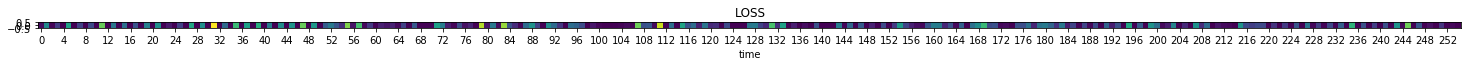

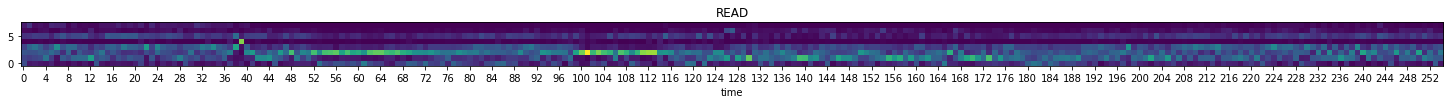

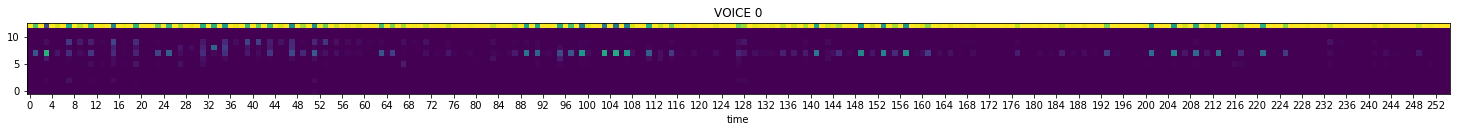

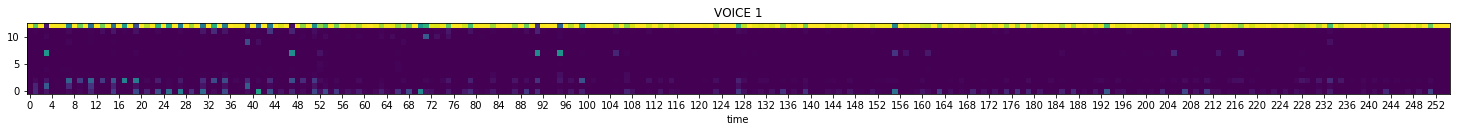

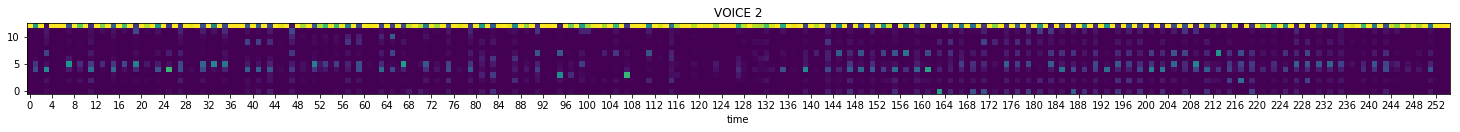

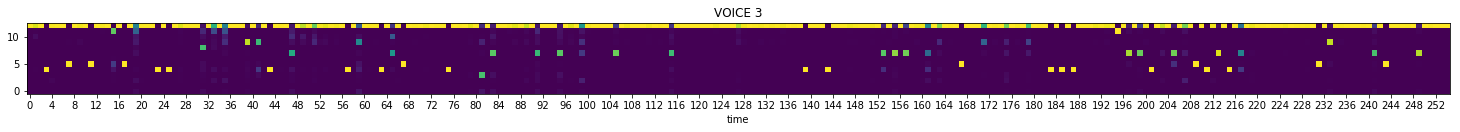

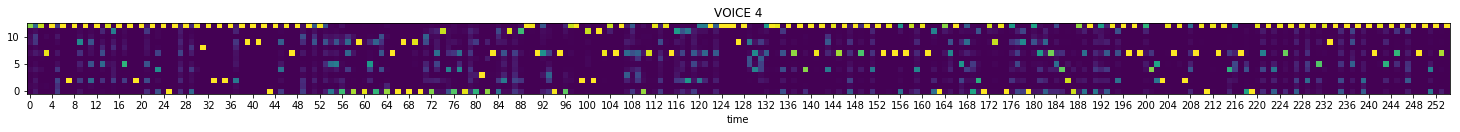

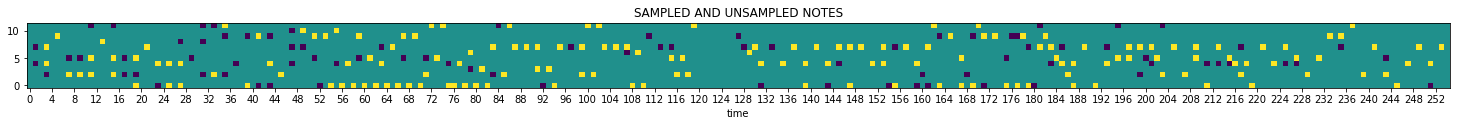

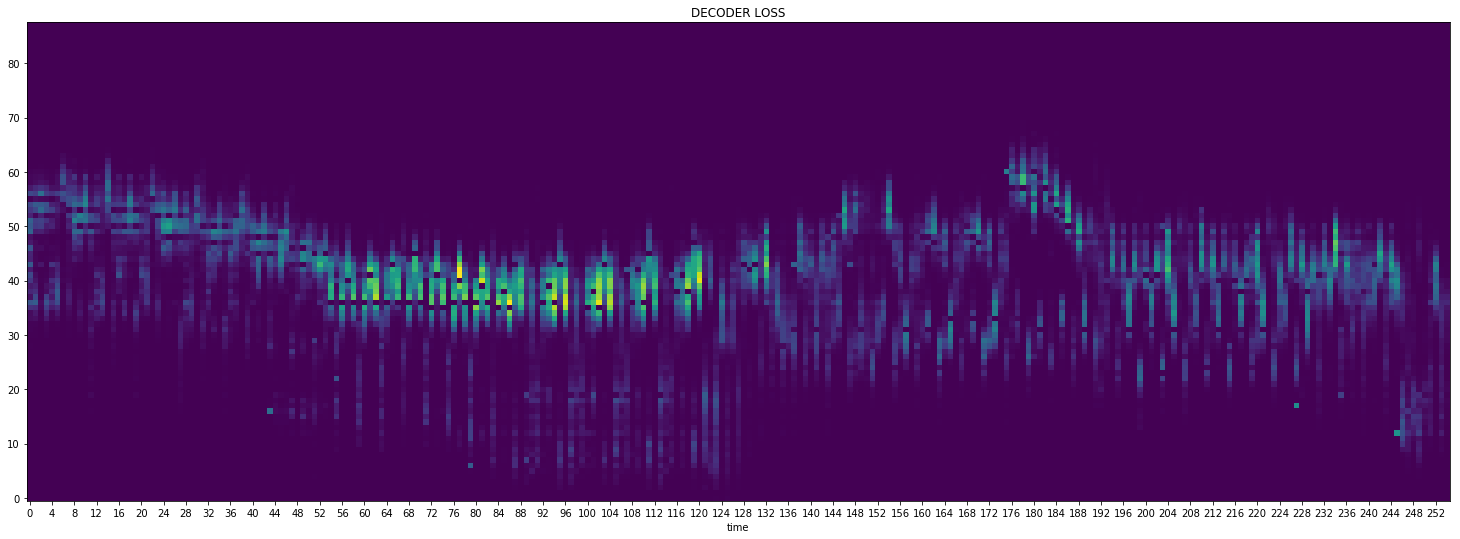

1.48137  mean for last:  1.52371


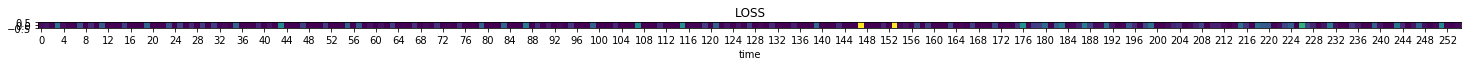

1.46892  mean for last:  1.53384


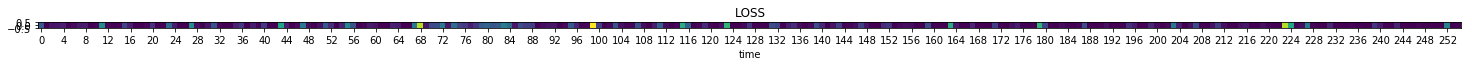

1.71649  mean for last:  1.52224


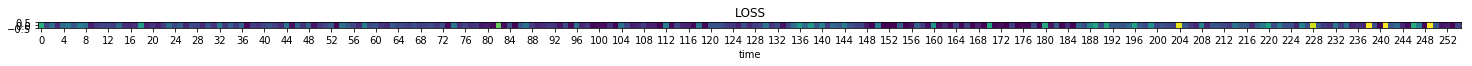

1.56563  mean for last:  1.53305


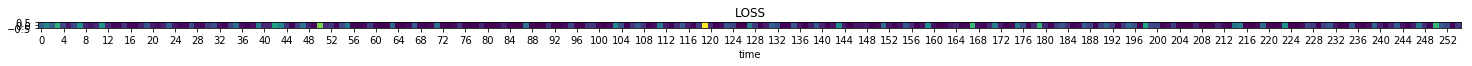

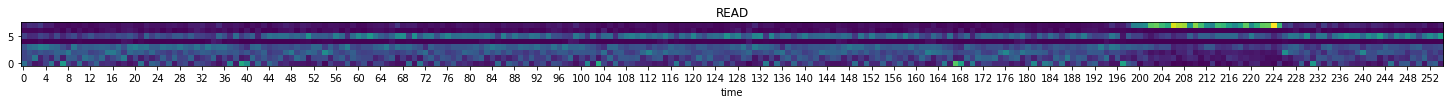

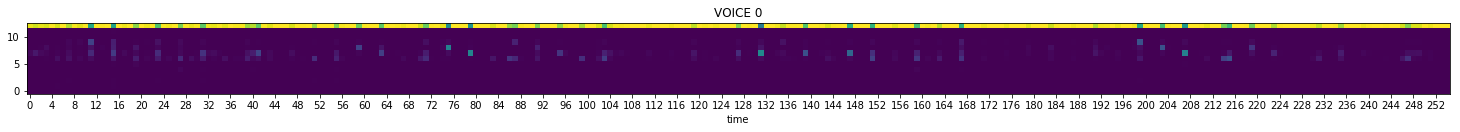

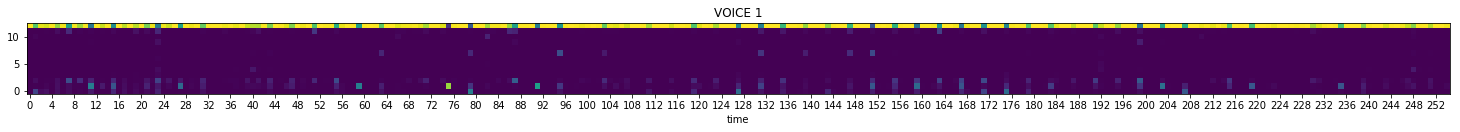

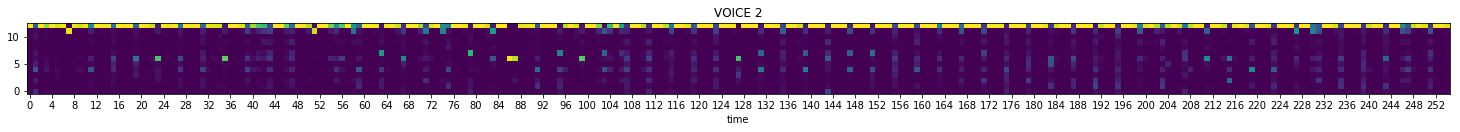

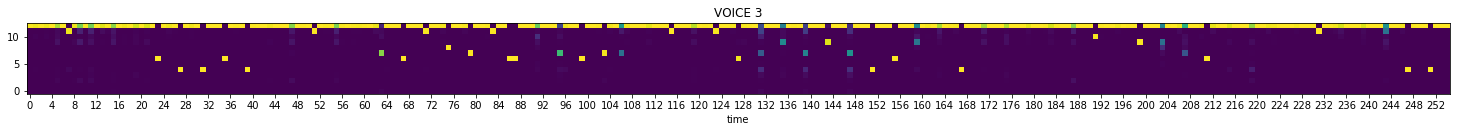

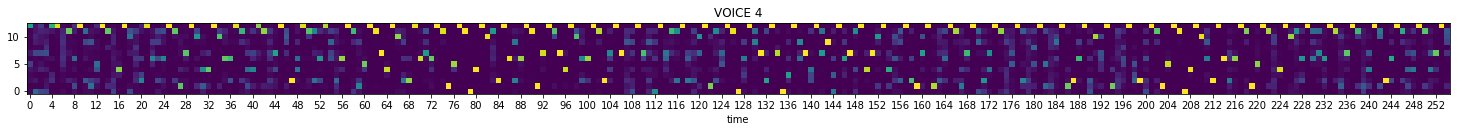

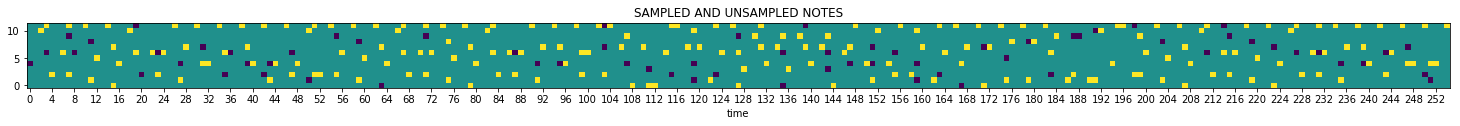

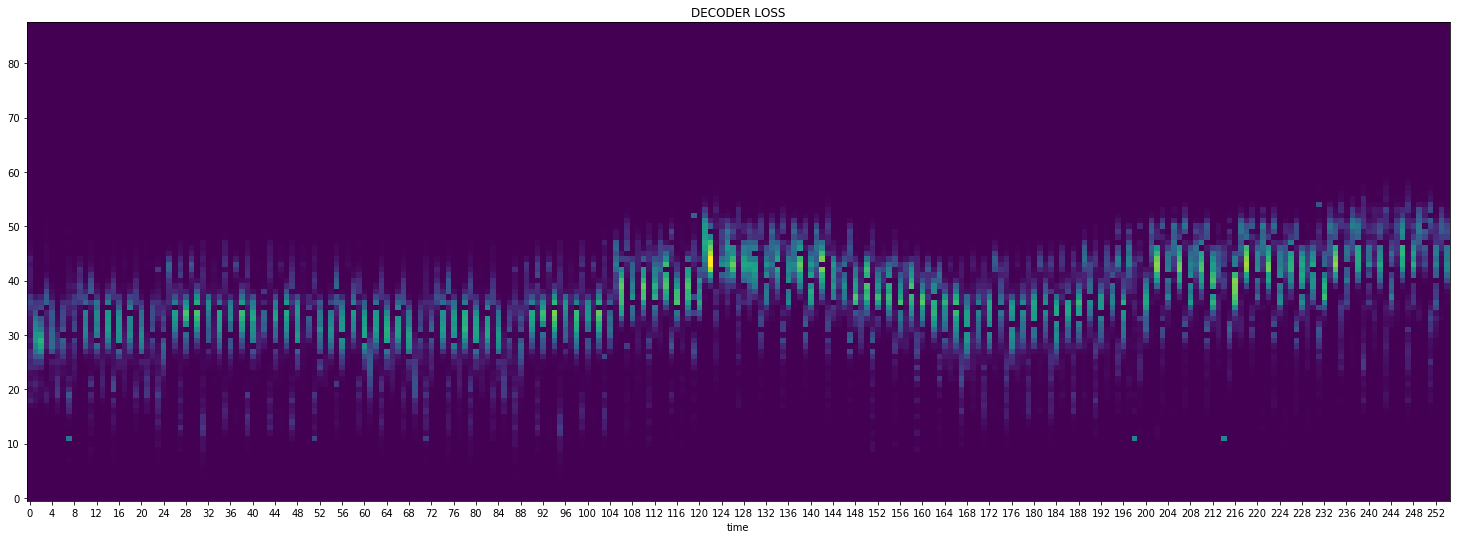

1.51581  mean for last:  1.50144


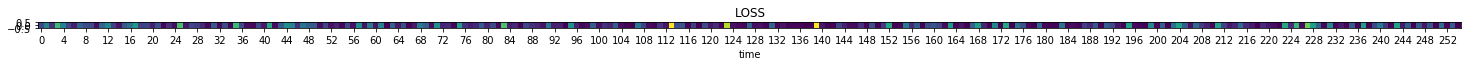

1.54577  mean for last:  1.52569


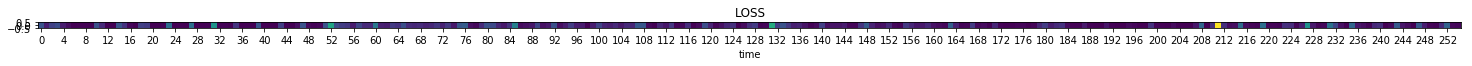

1.62139  mean for last:  1.51638


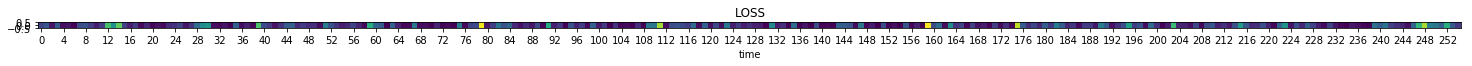

KeyboardInterrupt: 

In [25]:
training_steps = 200000
display_step = 50

#RECORD = 10

#losses = []
for step in range(training_steps + 1):

    batch_x, batch_h, batch_c, batch_d = generateBatch()

    fd = {X: batch_x, History: batch_h, Combinations: batch_c, was_sampled_notes_given: False, DecodedX: batch_d}
    _, L = sess.run([train_op, ce], feed_dict=fd)
    losses.append(L.mean())
    
    if np.isnan(L).any():
        print(" DAMN NAN ERROR")
        break
        
    if step % display_step == 0:
        print(L.mean(), " mean for last: ", np.array(losses)[-display_step:].mean())
        drawNotes(L[0], "LOSS")
        
        if step % 200 == 0:
            r = sess.run(read_index, feed_dict=fd)
            drawNotes(r[0], "READ")
            
            sn = sess.run(voices_proba, feed_dict=fd)
            for i in range(5):
                drawNotes(sn[i][0], "VOICE " + str(i))
            
            sn = sess.run(sampled_notes, feed_dict=fd)
            drawNotes(sn[0] - batch_x[0, 1:, :12]*(1-sn[0]), "SAMPLED AND UNSAMPLED NOTES")
                
            sn = sess.run(decoder_ce, feed_dict=fd)
            drawNotes(sn[0], "DECODER LOSS")
           
    if len(losses) > display_step and np.array(losses)[-display_step:].mean() < RECORD:
        RECORD = np.array(losses)[-display_step:].mean()
        saver.save(sess, "./tmp/100-100-100 HistoryUserScheme LSTM collapsed CP_dataset songs by fragments 9-history 6-times 5-40LSTMconditionalvoices ML 100-decoder lr=0.01.ckpt")
        
print("Optimization Finished!")

1.50144


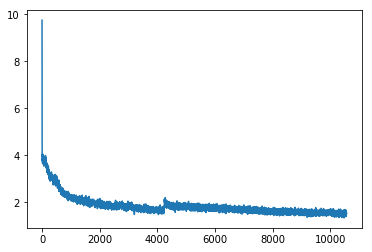

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

print(RECORD)
plt.plot(losses)

In [27]:
import mido
from mido import MidiFile
import numpy as np
import copy
import math

import matplotlib.pyplot as plt
%matplotlib inline

# для возможности прослушивания midi прямо в ноутбуке
HEARING_PORT = mido.open_output()
# для вывода массивов numpy целиком
np.set_printoptions(threshold=np.nan)

BASE_NOTE = 21
KEYS = 88
FREQ = 4  #ticks for beat

def drawSong(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.notes.shape[0] / 10, song.notes.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(song.name)
    plt.imshow(song.notes.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.notes.shape[0], 4))
    plt.show()

# Класс для создания нового миди файла
class MySong:
    def __init__(self, played_lines=[], finished=False):
        self.name = "Generated song!"
        self.notes = np.zeros((0, 88))

        self.mid = MidiFile(type=0)
        self.track = mido.MidiTrack()
        self.mid.tracks.append(self.track)

        self.time_passed = 0
        self.release = []

        for line in played_lines:
            self.add(line)
           
        if finished:
            self.finish()

    # добавление новых строк в ноты
    def add(self, played):
        self.notes = np.vstack([self.notes, played])

        # "отпуск" нот, сыгранных долю назад
        if played.sum() > 0:
            for i in self.release:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=0, time=self.time_passed))
                self.time_passed = 0
            self.release = []

        # добавление новых нот
        for i, key in enumerate(played):
            if key == 1:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
                self.time_passed = 0
                self.release.append(i)
        self.time_passed += self.mid.ticks_per_beat // FREQ

    # должна быть вызвана в конце создания файла
    def finish(self):
        for i in self.release:
            self.track.append(mido.Message('note_off', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.track.append(mido.Message('note_off', note=BASE_NOTE, velocity=0, time=self.time_passed))

    # воспроизведение
    def play(self):
        for msg in self.mid.play():
            HEARING_PORT.send(msg)

    # сохранение
    def save_file(self, name):
        self.mid.save(name + '.mid')

In [28]:
def pers_transform(song, stack_zeros=True):    
    wh = song[:]
    
    temp = wh.copy()
    for t in HISTORY_TIMES:
        h = np.roll(temp, t, axis=0)
        h[:t] = 0
        wh = np.concatenate([wh, h], axis=1)
          
    wh = np.concatenate([wh, times[:song.shape[0]]], axis=1)
            
    return wh

In [29]:
def octave_sample(dec_p, all_sampled):
    ans = (np.random.uniform(0, 1, 88) < 1 / (1 + np.exp(-dec_p))) * np.tile(all_sampled, 8)[:88]
    for i, val in enumerate(all_sampled):
        if val == 1 and ans[i::12].sum() == 0:
             ans[i + dec_p[i::12].argmax()*12] = 1
    return ans

In [30]:
res = []

In [39]:
LR = 0.0

for s in range(1):
    song = songs[np.random.randint(0, 100)][:16]
    gen = transform(song)[:, :12]
    
    transd = pers_transform(gen)        
    t, h = np.hstack([transd[:, :12], transd[:, -ADDITIONAL_INPUT_SIZE:]]), transd[:, 12:-ADDITIONAL_INPUT_SIZE].reshape(-1, len(HISTORY_TIMES), 12) 
    
    tsn = np.array(sess.run(sampled_notes_by_voices, feed_dict={X: np.repeat(t[None], batch_size, axis=0), 
                                                       History: np.repeat(h[None], batch_size, axis=0),
                                                       was_sampled_notes_given: False}))[:, 0]

    while len(gen) < 512:
        gen = np.vstack([gen, np.ones((12))])
        song = np.vstack([song, np.zeros((88))])

        transd = pers_transform(gen[-256:])
        t, h = np.hstack([transd[:, :12], transd[:, -ADDITIONAL_INPUT_SIZE:]]), transd[:, 12:-ADDITIONAL_INPUT_SIZE].reshape(-1, len(HISTORY_TIMES), 12)
        fd = {learning_rate: LR, X: np.repeat(t[None], batch_size, axis=0), History: np.repeat(h[None], batch_size, axis=0),
             was_sampled_notes_given: True, truly_sampled_notes: np.repeat(tsn[:, None, -254:], batch_size, axis=1),
             DecodedX: np.repeat(song[None, -256:], batch_size, axis=0)}
        sampled, dec_p, all_sampled = sess.run([sampled_notes_by_voices, decoder_p, sampled_notes], feed_dict=fd)
        
        tsn = np.concatenate([tsn, np.array(sampled)[:, 0, -1:]], axis=1)
        
        song[-1] = octave_sample(dec_p[0, -1], all_sampled[0, -1])
        gen[-1] = all_sampled[0, -1]
        
        print('|', end="")
    print("yeah!", s)
    res.append(song)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||yeah! 0


In [40]:
test = np.zeros((gen.shape[0], 88))
test[:, 42:54] = gen

ms = MySong(test, finished=True)

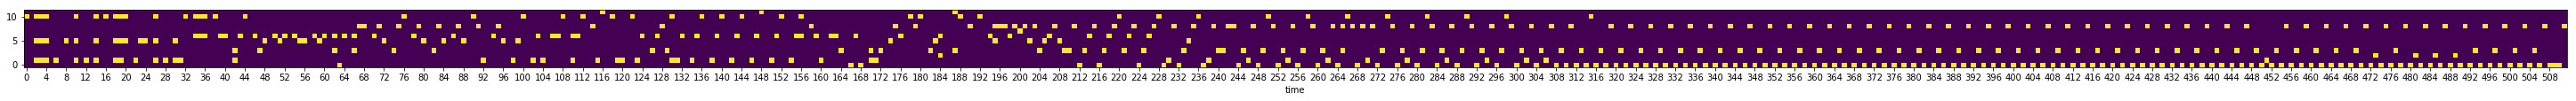

In [41]:
drawNotes(gen)

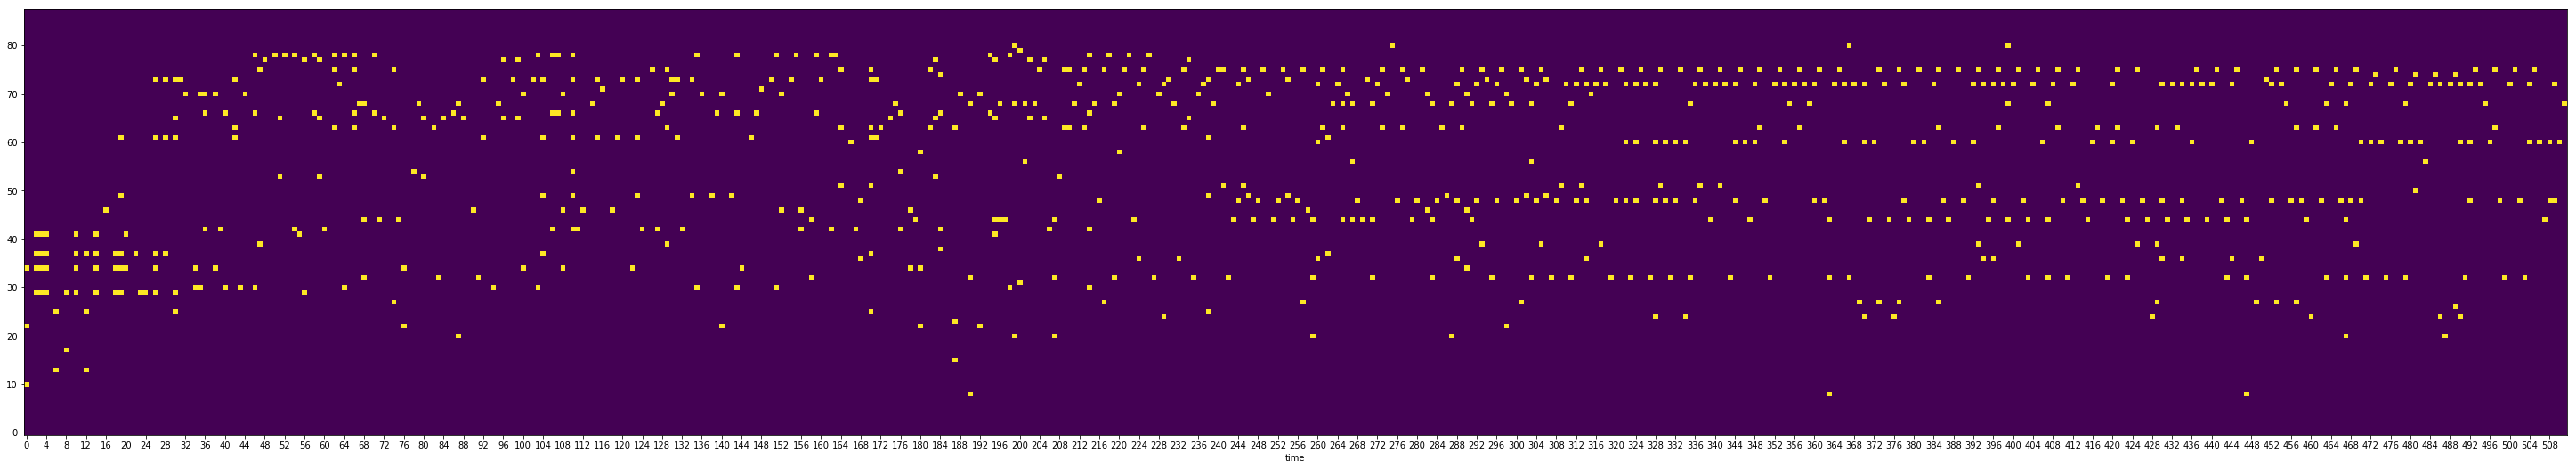

In [42]:
drawNotes(song)

In [43]:
ms.play()

In [44]:
ms = MySong(song, finished=True)

In [45]:
ms.play()

In [38]:
ms.save_file("ML")

In [ ]:
finale = np.zeros((0, 88))
for r in res:
    finale = np.vstack([finale, np.zeros((8, 88))])
    finale = np.vstack([finale, r[16:]])

In [ ]:
finale.shape

In [ ]:
finale = finale[:28760]

In [ ]:
ms = MySong(finale, finished=True)

In [ ]:
ms.save_file("4. Conditional Voices and HistoryUser and Metalearning 0.00001")